In [17]:
import eda
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. how many categories are in each folder
2. how many recordings in each category
3. Min/Max/Avg per category
4. Missing values
5. Find outliers
   1. per category
   2. visualizen

# Merge to df

In [3]:
def merge_geophone_falls(folder_path):
    """
    Merges all 'fall' data from CSV files in the given geophone folder.
    
    Parameters:
    - folder_path (str): Path to the geophone folder containing CSV files.
    
    Returns:
    - pd.DataFrame: Merged DataFrame with labeled columns.
    """
    all_data = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            parts = filename.split("_")
            
            if len(parts) < 5:
                print(f"Skipping file with unexpected format: {filename}")
                continue  # Skip files that don't match expected format
            
            fall_type = parts[0]  # First part of the filename
            fall_binary = parts[1]  # Check for fall keyword
            distance = parts[2]  # Third part of the filename
            person = parts[3]  # AW, AD, or 0
            floor_type = parts[-1].replace(".csv", "")  # Last part without ".csv"
            
            # Load CSV
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, header=None)
            
            # Take only the first 500 values
            # values = df.iloc[0, :500].tolist() if df.shape[1] >= 500 else df.iloc[0, :].tolist() + [None] * (500 - df.shape[1])
            for _, row in df.iterrows():
                # Ensure only 500 values are added
                values = row[:500].tolist() if len(row) >= 500 else row.tolist() + [None] * (500 - len(row))
                all_data.append([fall_type, fall_binary, distance, person, floor_type] + values)

    # Create DataFrame
    column_names = ["activity", "fall_binary", "distance_m", "person_binary", "floor"] + [f"value_{i}" for i in range(1, 501)]
    merged_df = pd.DataFrame(all_data, columns=column_names)

    return merged_df

# Example usage
df_geophone = merge_geophone_falls("../geophone")

# Add Weight Column

In [4]:
def add_weight_column(df):
    """
    Adds a new column 'weight' to the dataframe based on the person's identity and activity type.

    - 'AW' (Anna) -> 60kg
    - 'AD' (Adrian/David) -> 75kg
    - 'FOB' (Bag) -> 6kg
    - 'FOL' (Blackroll) -> 0.2kg

    Parameters:
    df (pd.DataFrame): Input dataframe containing 'person' and 'activity' columns.

    Returns:
    pd.DataFrame: Dataframe with the new 'weight' column.
    """
    # Mapping persons to their respective weights
    person_weight_map = {'AW': 60, 'AD': 75, '0': 0}

    # Insert weight column based on person mapping
    df.insert(4, 'weight', df['person_binary'].map(person_weight_map))

    # Update weight based on activity type
    df['weight'] = df.apply(lambda row: 
                            6 if row['activity'] == 'FOB' 
                            else (0.2 if row['activity'] == 'FOL' 
                                  else row['weight']), axis=1)
    
    return df

# Example usage:
df_geophone = add_weight_column(df_geophone)

# Map Person Column

In [5]:
def map_person_column(df, column_name='person_binary'):
    """
    Maps the 'person' column values to their numerical values.

    Parameters:
    - df (pd.DataFrame): Input dataframe containing 'person_binary' column.
    - column_name (str): Name of the column to be mapped.

    Returns:
    - pd.DataFrame: Dataframe with the mapped 'person' column.
    """
    df[column_name] = df[column_name].map({'AW': 1, 'AD': 1}).fillna(0).astype(int)
    return df

# Example usage:
df_geophone = map_person_column(df_geophone)

In [6]:
df_geophone.head()

,activity,fall_binary,distance_m,person_binary,weight,floor,value_1,value_2,value_3,value_4,...,value_491,value_492,value_493,value_494,value_495,value_496,value_497,value_498,value_499,value_500
0,FCS,1,1,1,75.0,H,59,-38,10,43,...,10,-8,-6,3,6,-5,10,10,-12,-6
1,FCS,1,1,1,75.0,H,104,-49,137,-46,...,-1,-15,-9,6,13,6,5,6,-4,-17
2,FCS,1,1,1,75.0,H,-11,48,-13,8,...,170,-107,-246,70,158,110,-52,-100,63,76
3,FCS,1,1,1,75.0,H,16,-11,22,4,...,2,-8,-13,0,13,1,-1,4,4,-9
4,FCS,1,1,1,75.0,H,5,-11,-4,2,...,36,12,2,13,8,7,9,-33,-11,-11


In [7]:
df_geophone.to_csv("merged_geophone_falls.csv", index=False)

In [21]:
# group df_geophone by activity and count
df_geophone.groupby('activity').size()

activity
CD      20
FCS     60
FOB     60
FOL     60
KD      10
MA      45
RBS    120
S       45
SC      60
WBS     90
dtype: int64

In [22]:
df_geophone.groupby('fall_binary').size()

fall_binary
0    510
1     60
dtype: int64

# Features

In [23]:
def get_features(df: pd.DataFrame, groupby_col: str = 'activity'):
    """
    Extracts features from the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - groupby_col (str): Column to group by.

    Returns:
    - pd.DataFrame: DataFrame with extracted features.
    """
    return_df = pd.DataFrame()
    # Extract features
    return_df["recording"] = df.iloc[:, :6].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    return_df["mean"] = df.iloc[:, 6:].mean(axis=1)
    return_df["std"] = df.iloc[:, 6:].std(axis=1)
    return_df["min"] = df.iloc[:, 6:].min(axis=1)
    return_df["max"] = df.iloc[:, 6:].max(axis=1)
    return_df["median"] = df.iloc[:, 6:].median(axis=1)
    return_df["range"] = return_df["max"] - return_df["min"]

    return return_df

In [24]:
df_geophone_features = get_features(df_geophone)

In [42]:
print(df_geophone_features)

             recording    mean         std    min   max  median  range
0    FCS_1_1_AD_75.0_H -12.574  332.233428  -2904  3335     0.0   6239
1    FCS_1_1_AD_75.0_H -15.622  332.036962  -5425  1794    -1.0   7219
2    FCS_1_1_AD_75.0_H  22.256  556.031918  -4533  8664     2.0  13197
3    FCS_1_1_AD_75.0_H  19.398  467.826539  -1911  8603     0.0  10514
4    FCS_1_1_AD_75.0_H -18.060  782.252039 -13943  6241     1.0  20184
..                 ...     ...         ...    ...   ...     ...    ...
565    FOB_0_1_0_6.0_H   1.426  102.783547   -909  1386     0.0   2295
566    FOB_0_1_0_6.0_H -18.440  287.731983  -5766   538    -1.0   6304
567    FOB_0_1_0_6.0_H   0.016   20.458564   -219    82     0.0    301
568    FOB_0_1_0_6.0_H   1.168  283.493769  -1626  5762     0.0   7388
569    FOB_0_1_0_6.0_H   2.896   91.252283   -927  1157     0.5   2084

[570 rows x 7 columns]


In [25]:
print(df_geophone.iloc[0, 6:])

value_1       59
value_2      -38
value_3       10
value_4       43
value_5      -50
            ... 
value_496     -5
value_497     10
value_498     10
value_499    -12
value_500     -6
Name: 0, Length: 500, dtype: object


# Scatterplot

In [45]:
def plot_scatter(df, labels = False):
    """
    Creates a scatter plot with mean on the x-axis, range on the y-axis,
    and colors based on the recording category. Adds tooltips for each point.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'mean', 'range', and 'recording' columns.
    """
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=df, x="mean", y="range", hue="recording", palette="tab10", alpha=0.8, edgecolor="black")
    
    # Labels and title
    plt.xlabel("std")
    plt.ylabel("Range")
    plt.title("Scatter Plot of Mean vs Range Colored by Recording")
    
    # Add annotations
    if labels:
        for i in range(df.shape[0]):
            plt.annotate(df['recording'][i], (df['std'][i], df['range'][i]), fontsize=8, alpha=0.7)
    
    # Legend adjustments
    plt.legend(title="Recording", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    plt.show()


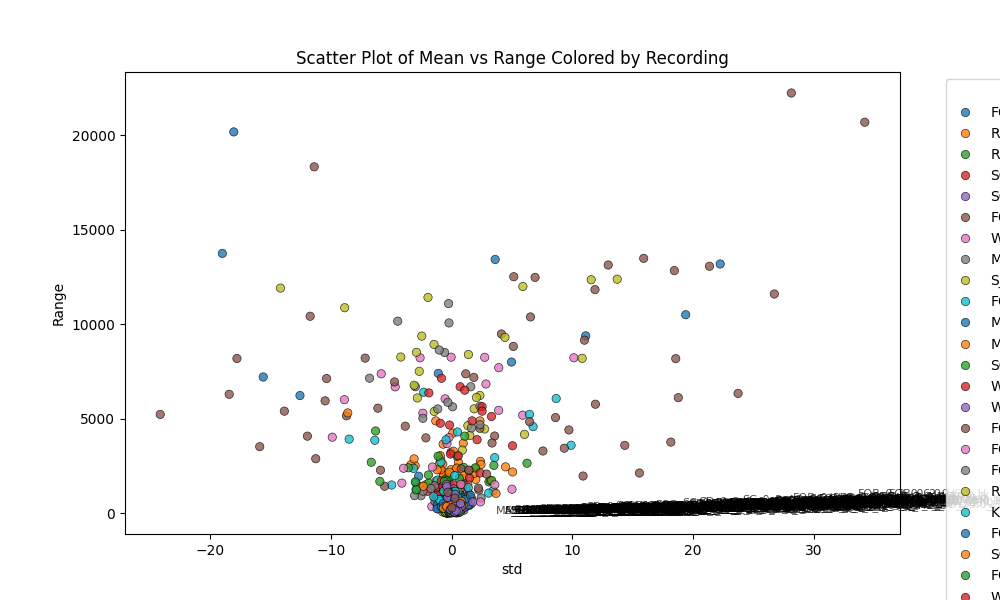

In [48]:
plot_scatter(df_geophone_features, labels=True)